In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import UnivariateSpline
from scipy.integrate import trapz, cumtrapz
import optimum_reparamN2 as orN2
import optimum_reparam_N as orN
from joblib import Parallel, delayed


df = pd.read_csv("./data/sample_data2.csv")
print(df.shape)
df.head()

(288, 102)


,C_0,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9,...,C_92,C_93,C_94,C_95,C_96,C_97,C_98,C_99,C_100,C_101
0,17.85,18.48,18.80,17.85,17.85,18.48,18.17,17.53,18.17,18.17,...,17.53,18.48,19.12,17.85,16.58,16.26,17.21,16.26,15.3,17.85
1,17.85,18.17,18.48,17.53,17.53,18.48,18.17,17.53,18.17,18.17,...,17.53,18.17,19.12,17.85,16.58,15.94,17.21,16.26,15.3,17.85
2,17.85,18.17,18.48,17.53,17.85,18.48,18.17,17.53,18.17,18.17,...,17.53,18.17,19.12,17.85,16.58,16.26,17.21,16.26,15.3,17.85
3,17.85,18.17,18.80,17.53,17.53,18.48,18.17,17.53,18.17,18.17,...,17.53,18.17,19.12,17.85,16.58,15.94,17.21,16.26,15.3,17.85
4,17.85,18.17,18.80,17.53,17.85,18.48,18.17,17.53,18.17,18.17,...,17.53,18.17,19.12,17.85,16.58,16.26,17.21,16.26,15.3,17.85


In [2]:
start = 0
n_timepts = 20

In [3]:
def restart():    
    F = df[start:n_timepts].iloc[:-1,:-1].to_numpy()
    time_points = np.linspace(0, 1, F.shape[0])

    return F, time_points

F, time_points = restart()

In [4]:
global g 
global gam

def f_to_srsf(f, time, smooth=False):
    eps = np.finfo(np.double).eps
    f0, g, g2 = gradient_spline(time, f, smooth)
    q = g / np.sqrt(np.fabs(g) + eps)
    return q

def gradient_spline(time, f, smooth=False):
    M = f.shape[0]

    if f.ndim > 1:
        N = f.shape[1]
        f0 = np.zeros((M, N))
        g = np.zeros((M, N))
        g2 = np.zeros((M, N))
        for k in range(0, N):
            if smooth:
                spar = time.shape[0] * (.025 * np.fabs(f[:, k]).max()) ** 2
            else:
                spar = 0
            tmp_spline = UnivariateSpline(time, f[:, k], s=spar)
            f0[:, k] = tmp_spline(time)
            g[:, k] = tmp_spline(time, 1)
            g2[:, k] = tmp_spline(time, 2)
    else:
        if smooth:
            spar = time.shape[0] * (.025 * np.fabs(f).max()) ** 2
        else:
            spar = 0
        tmp_spline = UnivariateSpline(time, f, s=spar)
        f0 = tmp_spline(time)
        g = tmp_spline(time, 1)
        g2 = tmp_spline(time, 2)

    return f0, g, g2

def optimum_reparam(q1, time, q2, method="DP2", lam=0.0, penalty="roughness", grid_dim=7):
    if penalty == "l2gam" and (method == "DP" or method == "DP2"):
        raise Exception('penalty not implemented')
    if penalty == "l2psi" and (method == "DP" or method == "DP2"):
        raise Exception('penalty not implemented')
    if penalty == "geodesic" and (method == "DP" or method == "DP2"):
        raise Exception('penalty not implemented')
    
    if method == "DP2":
        if q1.ndim == 1 and q2.ndim == 1:
            gam = orN2.coptimum_reparam(np.ascontiguousarray(q1), time,
                                        np.ascontiguousarray(q2), lam, grid_dim)

        if q1.ndim == 1 and q2.ndim == 2:
            gam = orN2.coptimum_reparamN(np.ascontiguousarray(q1), time,
                                        np.ascontiguousarray(q2), lam, grid_dim)

        if q1.ndim == 2 and q2.ndim == 2:
            gam = orN2.coptimum_reparamN2(np.ascontiguousarray(q1), time,
                                        np.ascontiguousarray(q2), lam, grid_dim)
        
    else:
        raise Exception('Invalid Optimization Method')

    return gam

def elastic_distance(f1, f2, time, method="DP2", lam=0.0):
    q1 = f_to_srsf(f1, time)
    q2 = f_to_srsf(f2, time)

    gam = optimum_reparam(q1, time, q2, method, lam)
    fw = warp_f_gamma(time, f2, gam)
    qw = warp_q_gamma(time, q2, gam)

    Dy = np.sqrt(trapz((qw - q1) ** 2, time))
    M = time.shape[0]

    time1 = np.linspace(0,1,M)
    binsize = np.mean(np.diff(time1))
    psi = np.sqrt(np.gradient(gam,binsize))
    q1dotq2 = trapz(psi, time1)
    if q1dotq2 > 1:
        q1dotq2 = 1
    elif q1dotq2 < -1:
        q1dotq2 = -1

    Dx = np.real(np.arccos(q1dotq2))

    return Dy, Dx

def elastic_outliers(F, depths):

    amp = depths['amplitude']
    phs = depths['phase']

    amp_100 = np.max(amp)
    phs_100 = np.max(phs)

    amp_50 = np.percentile(amp, 50)
    phs_50 = np.percentile(phs, 50)

    amp_iqr = amp_100 - amp_50 
    phs_iqr = phs_100 - phs_50

    amp_lim = max(amp_50 - 1.5 * amp_iqr, 0)
    phs_lim = max(phs_50 - 1.5 * phs_iqr, 0)

    amp_thre = np.percentile(amp, 0.5 * 100)
    phs_thre = np.percentile(phs, 0.5 * 100)

    amp_out = (amp < amp_lim) & (amp < amp_thre)
    phs_out = (phs < phs_lim) & (phs < phs_thre)

    labels = {'amp': amp_out, 'phs': phs_out}

    return labels

def warp_f_gamma(time, f, gam):
    f_temp = np.interp((time[-1] - time[0]) * gam + time[0], time, f)
    return f_temp

def warp_q_gamma(time, q, gam):
    M = gam.size
    gam_dev = np.gradient(gam, 1 / np.double(M - 1))
    tmp = np.interp((time[-1] - time[0]) * gam + time[0], time, q)

    q_temp = tmp * np.sqrt(gam_dev)

    return q_temp

def distmat(f, f1, time, idx, method):
    N = f.shape[1]
    dp = np.zeros(N)
    da = np.zeros(N)

    for jj in range(N):
        Dy,Dx = elastic_distance(f[:,jj], f1, time, method)

        da[jj] = Dy
        dp[jj] = Dx
    
    return(da, dp)

def elastic_depth(F, time_points, method="DP2", lam=0.0, parallel=True):
    obs, fns = F.shape

    amp_dist = np.zeros((fns,fns))
    phs_dist = np.zeros((fns,fns))

    if parallel:
        out = Parallel(n_jobs=-1)(delayed(distmat)(F, F[:, n], time_points, n, method) for n in range(fns))
        for i in range(0, fns):
            amp_dist[i, :] = out[i][0]
            phs_dist[i, :] = out[i][1]
    else:
        for i in range(0, fns):
            amp_dist[i, :], phs_dist[i, :] = distmat(F, F[:, i], time_points, i, method)
    
    amp_dist = amp_dist + amp_dist.T
    phs_dist = phs_dist + phs_dist.T

    amp = 1 / (1 + np.median(amp_dist,axis=0))
    phase = 1 / (1 + np.median(phs_dist,axis=0))
    phase = ((2+np.pi)/np.pi) * (phase - 2/(2+np.pi))

    return amp, phase

In [5]:
F, time_points = restart()
amp_depth, phs_depth = elastic_depth(F, time_points)
depths = {'amplitude': amp_depth, 'phase': phs_depth}
amp_depth, phs_depth

(array([0.24455954, 0.23574058, 0.21988801, 0.26540288, 0.20919682,
        0.23999841, 0.19681455, 0.21178533, 0.22130809, 0.27043148,
        0.25378555, 0.28276621, 0.22010679, 0.24816159, 0.23620569,
        0.23118673, 0.26257848, 0.22190876, 0.22865631, 0.22022211,
        0.23426764, 0.26368799, 0.23722823, 0.23426764, 0.22000883,
        0.2477153 , 0.24647102, 0.21823807, 0.24455954, 0.2300494 ,
        0.23481698, 0.25912019, 0.23410827, 0.23368597, 0.22784171,
        0.20021857, 0.25912019, 0.24647102, 0.23368597, 0.25872056,
        0.20555252, 0.26293163, 0.24634953, 0.22260249, 0.24905818,
        0.2294437 , 0.25890839, 0.26524014, 0.24905818, 0.27148481,
        0.25808486, 0.27208113, 0.24422319, 0.26760063, 0.24422319,
        0.25089876, 0.26197828, 0.25703677, 0.28192995, 0.26369772,
        0.23387981, 0.2217911 , 0.25808486, 0.25293528, 0.25808486,
        0.2598769 , 0.25728226, 0.27549033, 0.25808486, 0.27645253,
        0.27345249, 0.25808486, 0.2317627 , 0.25

In [6]:
F.shape # (time points, functions)

(19, 101)

In [7]:
len(depths['amplitude'])

101

In [8]:
elastic_out = elastic_outliers(F, depths)
print('number of labels:',len(elastic_out['amp']))
elastic_out['amp']

number of labels: 101


array([False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [9]:
def prog_update(F, f, depths, labels, method="DP2", lam=0.0, parallel=True):
    obs, fns = F.shape

    amp_dist = np.zeros(fns)
    phs_dist = np.zeros(fns)

    # computing elastic distances 
    amp_dist, phs_dist = distmat(F, f, time_points, 0, method)

    amp_new = 1 / (1 + np.median(amp_dist,axis=0))
    phase_new = 1 / (1 + np.median(phs_dist,axis=0))
    phase_new = ((2+np.pi)/np.pi) * (phase_new - 2/(2+np.pi))

    # computing outlier label for new amp/phase depth
    amp_depths = depths['amplitude']
    phs_depths = depths['phase']

    amp_100 = np.max(amp_depths)
    phs_100 = np.max(phs_depths)

    amp_50 = np.percentile(amp_depths, 50)
    phs_50 = np.percentile(phs_depths, 50)

    amp_iqr = amp_100 - amp_50 
    phs_iqr = phs_100 - phs_50

    amp_lim = max(amp_50 - 1.5 * amp_iqr, 0)
    phs_lim = max(phs_50 - 1.5 * phs_iqr, 0)

    amp_thre = np.percentile(amp_depths, 0.5 * 100)
    phs_thre = np.percentile(phs_depths, 0.5 * 100)

    amp_out = (amp_new < amp_lim) & (amp_new < amp_thre)
    phs_out = (phase_new < phs_lim) & (phase_new < phs_thre)

    # updating labels
    labels['amp'] = np.append(labels['amp'], amp_out)
    labels['phs'] = np.append(labels['phs'], phs_out)

    # updating depths
    depths['amplitude'] = np.append(depths['amplitude'], amp_new)
    depths['phase'] = np.append(depths['phase'], phase_new)

    return labels

In [10]:
F_new = df[start:n_timepts].iloc[:-1,101].T.to_numpy()
out_labels = prog_update(F, F_new, depths, elastic_out)

In [11]:
len(depths['amplitude'])

102

In [12]:
print('number of labels:',len(out_labels['amp']))
out_labels['amp']

number of labels: 102


array([False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [13]:
df.iloc[-1,:]

C_0      16.89
C_1      16.89
C_2      17.53
C_3      16.58
C_4      16.58
         ...  
C_97     15.94
C_98     17.21
C_99     16.26
C_100    15.30
C_101    17.85
Name: 287, Length: 102, dtype: float64

In [14]:
x = df.iloc[-1,:].to_numpy().reshape(1, -1) # new time points shape (1, 102)
x

array([[16.89, 16.89, 17.53, 16.58, 16.58, 17.21, 16.58, 16.26, 17.21,
        16.89, 17.85, 15.62, 16.89, 17.85, 17.85, 16.89, 16.89, 16.58,
        17.53, 15.94, 17.21, 17.53, 17.53, 16.89, 16.58, 16.89, 17.21,
        16.58, 17.21, 18.17, 17.85, 16.58, 15.94, 17.21, 17.21, 16.89,
        17.85, 18.17, 17.85, 17.21, 15.94, 16.89, 16.89, 15.94, 15.62,
        16.89, 16.89, 16.26, 16.89, 17.21, 17.85, 17.21, 15.94, 16.58,
        16.58, 15.62, 16.26, 17.53, 17.53, 16.89, 16.58, 17.53, 17.53,
        16.89, 16.58, 16.89, 17.85, 15.94, 16.89, 17.21, 17.21, 16.58,
        16.89, 17.53, 17.21, 16.26, 15.62, 16.58, 16.26, 15.3 , 17.21,
        17.85, 18.17, 16.89, 15.62, 16.58, 16.26, 15.62, 16.26, 16.89,
        17.53, 15.94, 16.58, 16.89, 17.85, 16.58, 16.58, 15.94, 17.21,
        16.26, 15.3 , 17.85]])

In [15]:
x.shape

(1, 102)

In [16]:
F = df[start:n_timepts].iloc[:-1,:].to_numpy()
time_points = np.linspace(0, 1, F.shape[0])

In [17]:
x[:,0]

array([16.89])

In [18]:
np.append(F[:,0], x[:,0])

array([17.85, 17.85, 17.85, 17.85, 17.85, 17.85, 17.85, 17.85, 17.85,
       17.85, 17.85, 16.89, 16.89, 16.89, 16.89, 16.89, 16.89, 16.89,
       18.8 , 16.89])

In [19]:
np.vstack((F, x))

array([[17.85, 18.48, 18.8 , ..., 16.26, 15.3 , 17.85],
       [17.85, 18.17, 18.48, ..., 16.26, 15.3 , 17.85],
       [17.85, 18.17, 18.48, ..., 16.26, 15.3 , 17.85],
       ...,
       [16.89, 16.89, 17.21, ..., 16.26, 15.3 , 17.85],
       [18.8 , 18.48, 17.21, ..., 16.26, 15.3 , 17.85],
       [16.89, 16.89, 17.53, ..., 16.26, 15.3 , 17.85]])

In [20]:
len(depths['amplitude'])

102

In [32]:
def inc_update(F, x, depths, threshold=0.8, window_size=10, method="DP2", lam=0.0, parallel=True):
    # Append new data point to the existing time series data
    F_inc = np.vstack((F, x)) 
    
    obs, fns = F.shape
    obs2, fns2 = F_inc.shape
    
    # Ensure the number of functions is the same in the new and old data
    if (fns != fns2):
        raise Exception('Error: number of functions in increment != number of functions in F')
    
    t1 = np.linspace(0, 1, F.shape[0])  # (19, 102) -> original time points
    t2 = np.linspace(0, 1, F_inc.shape[0])  # (20, 102) -> updated time points

    # Iterate through each function (column) of the time series data
    for i in range(fns):
        # Get the old and new time series for this function
        f1 = F[:, i]  # Previous data (old)
        f2 = F_inc[:, i]  # New data (with the added point)
        
        # Calculate the gradients (rate of change) for the old and new data
        grad_f1 = np.gradient(f1)  # Gradient of the old data (f1)
        grad_f2 = np.gradient(f2)  # Gradient of the new data (f2)
        
        # Take the last `window_size` data points and calculate the gradient over this window
        grad_f1_window = grad_f1[-window_size:]  # Last `window_size` data points of the old data's gradient
        grad_f2_window = grad_f2[-window_size:]  # Last `window_size` data points of the new data's gradient

        # Calculate the difference between the gradients of the new and old data
        grad_diff = np.linalg.norm(grad_f2_window - grad_f1_window)
        
        # If the gradient difference exceeds the threshold, calculate elastic depths for all column pairs
        if grad_diff > threshold:
            # Iterate over all pairs of columns in the dataset F_inc
            for i_col in range(fns):
                for j_col in range(i_col + 1, fns):  # Only compute for distinct pairs (i_col != j_col)
                    f1_col = F_inc[:, i_col]  # Function/column i
                    f2_col = F_inc[:, j_col]  # Function/column j
                    
                    # Call the function to compute the elastic distance (depth) between the columns
                    amp_new, phase_new = distmat(F_inc, f1_col, t2, 0, method)  # Assuming distmat computes the distance
                    # You may need to adapt this if `distmat` requires specific parameters

                    # Normalize the amplitude and phase depths
                    amp_new = 1 / (1 + np.median(amp_new))
                    phase_new = 1 / (1 + np.median(phase_new))
                    phase_new = ((2 + np.pi) / np.pi) * (phase_new - 2 / (2 + np.pi))

                    # Update the depth values for amplitude and phase
                    depths['amplitude'][i_col] = amp_new
                    depths['phase'][i_col] = phase_new
                    depths['amplitude'][j_col] = amp_new
                    depths['phase'][j_col] = phase_new
    
    return depths


In [33]:
out_labels = inc_update(F, x, depths)

KeyboardInterrupt: 

numpy.float64

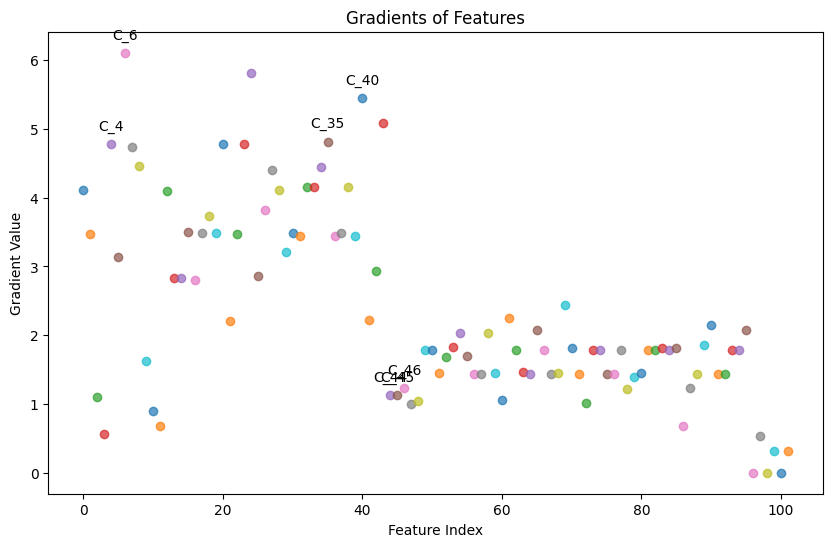

In [31]:
import matplotlib.pyplot as plt

# Assuming out_labels is a list of scalar values or arrays of gradient values (as before)
# Also assuming you have a corresponding list or index that identifies the columns, e.g., ['C_1', 'C_2', ..., 'C_46']

# Columns to annotate
columns_to_annotate = ['C_4', 'C_6', 'C_35', 'C_40', 'C_44', 'C_45', 'C_46']

# Create a figure for plotting
plt.figure(figsize=(10, 6))

# Iterate through each gradient in out_labels
for i, gradient in enumerate(out_labels):
    # If the gradient is a list or array (time series), plot it
    if isinstance(gradient, np.ndarray):
        plt.scatter(range(len(gradient)), gradient, alpha=0.7)
    else:
        # If the gradient is a scalar, plot it as a single point
        plt.scatter(i, gradient, alpha=0.7)
    
    # Check if the current column is in the columns_to_annotate
    column_name = f'C_{i}'  # Assuming i+1 corresponds to the correct column index ('C_1', 'C_2', etc.)
    if column_name in columns_to_annotate:
        # Annotate the point with its corresponding column name
        plt.annotate(column_name, (i, gradient), textcoords="offset points", xytext=(0, 10), ha='center')

# Customize the plot
plt.title("Gradients of Features")
plt.xlabel("Feature Index")
plt.ylabel("Gradient Value")

# Show the plot
plt.show()




In [35]:
#symmetry tets
import numpy as np

F = np.random.rand(20, 5)  # Example data with 20 observations and 5 functions
t = np.linspace(0, 1, F.shape[0])
C0 = F[:, 0]  # First column
C1 = F[:, 1]  # Second column


amp_C0_C1, phase_C0_C1 = distmat(F, C1, t, 0, "DP2")
dist_C0_C1 = (1 / (1 + np.median(amp_C0_C1)), 1 / (1 + np.median(phase_C0_C1)))

# Calculate elastic distance from C1 to C0
amp_C1_C0, phase_C1_C0 = distmat(F, C0, t, 1, "DP2")
dist_C1_C0 = (1 / (1 + np.median(amp_C1_C0)), 1 / (1 + np.median(phase_C1_C0)))

# Test symmetry
print("Distance C0 -> C1:", dist_C0_C1)
print("Distance C1 -> C0:", dist_C1_C0)

if np.allclose(dist_C0_C1, dist_C1_C0, atol=1e-6):
    print("Elastic distance is symmetric.")
else:
    print("Elastic distance is not symmetric.")


Distance C0 -> C1: (0.37453781951854453, 0.841327872534578)
Distance C1 -> C0: (0.28003738307688647, 0.8176669547386526)
Elastic distance is not symmetric.


In [36]:
amp_C0_C1 == amp_C1_C0

array([False, False, False, False, False])